In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params

import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42


In [3]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987
    R = 0.0083145
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    basef = a * x + b
    baseu = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_bot, b = init_b_bot, c = init_m_top, d = init_b_top, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['b'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    
    # set minimum f -1000
    #melt_params['f'].min = -1000
    # top slope = bot slope
    #melt_params['a'].expr = 'c'
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)
    # try:
    #     melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    # except ValueError as e:
    #     if "The model function generated NaN values" in str(e):
    #         print("Caught the NaN generation error. Handling it...")
    #         return None
    #         # Handle the error, for example, by logging it, adjusting model parameters, or using default values
            
    #     else:
    #         print('some other error')
    #         # If the error message is different, you might want to raise the error again or handle it differently
    #         return None
    
    # remove outlier outside 1.5sigma
    # outlier = np.abs(melt_result.residual) > 150 * np.std(melt_result.residual)
    # if sum(outlier) > 0:
    #     x_no_outlier = x[~outlier]
    #     y_no_outlier = y[~outlier]
    #     melt_result = melt_model.fit(y_no_outlier, melt_params, x = x_no_outlier, method = 'least_squares')

    return melt_result

# calculate smoothed best-fit values based on melt_result
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

In [4]:
# Load data

global_fits = '../06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results_withCs.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)


# get experimental info
main_db  = '../06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits.columns

Index(['site', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2', 'stderr_log_kappa',
       'stderr_log_kdeg', 'stderr_log_fmod_0', 'rg_id', 'temperature',
       'disp_name', 'buffer_id'],
      dtype='object')

In [5]:
def fit_melting_curve(fits, construct, site, kadd_arrhenius = None, agg_mean = False):
    """
    Fit a melting curve for a given construct and site.

    Parameters:
        fits (pd.DataFrame): DataFrame containing the fit data.
        construct (str): The construct name to filter the data.
        site (int): The site number to filter the data.
        kadd_arrhenius (lmfit LinearModel result): The result of the kadd Arrhenius fit.
        agg_mean (bool): Whether to aggregate the data by mean temperature.
            Default is False.  
    Returns:
        tuple: A tuple containing:
            - fits_filt (pd.DataFrame): Filtered DataFrame for the given construct and site.
            - melt_result (lmfit.model.ModelResult): Result of the melting curve fit.
            - smooth_x (np.ndarray): Smoothed x-values for the fitted curve.
            - smooth_y (np.ndarray): Smoothed y-values for the fitted curve.
            - lnkobs_20C (float): Natural log of kobs at 20°C.
            - lnkobs_20C_err (float): Uncertainty in the natural log of kobs at 20°C.
            - lnkadd (float): Natural log of kadd at 20°C.
            - lnkadd_err (float): Uncertainty in the natural log of kadd at 20°C.
            - kadd_curve_x (np.ndarray): x-values for the kadd curve.
            - kadd_curve_y (np.ndarray): y-values for the kadd curve.
    
    """
    fits_filt = fits[(fits['disp_name'] == construct) & (fits['site'] == site)].copy()
    fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
    fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

    if agg_mean:
        fits_filt = fits_filt.groupby('temperature').mean().reset_index()

    if kadd_arrhenius is not None:
        # get kadd slope and intercept
        kadd_slope = kadd_arrhenius.params['slope'].value
        kadd_intercept = kadd_arrhenius.params['intercept'].value

        # for drawing upper baseline
        kadd_curve_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
        kadd_curve_y = kadd_slope * kadd_curve_x + kadd_intercept

        # calculate lnkadd at 20C
        lnkadd = kadd_arrhenius.eval(x = 1 / (273.15 + 20))
        lnkadd_err = kadd_arrhenius.eval_uncertainty(x = 1 / (273.15 + 20))

        kadd_params = (kadd_slope, kadd_intercept)
        melt_result = fit_meltcurve(fits_filt['inv_temp'], fits_filt['log_kobs'], kadd_params = kadd_params)

    else:
        melt_result = fit_meltcurve(fits_filt['inv_temp'], fits_filt['log_kobs'])

        # for drawing upper baseline
        slope = melt_result.params['c'].value
        intercept = melt_result.params['d'].value
        kadd_curve_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
        kadd_curve_y = slope * kadd_curve_x + intercept

        lnkadd = slope * (1 / (273.15 + 20)) + intercept
        lnkadd_err = 0

    smooth_x, smooth_y = calc_smoothed_best_fit(melt_result)

    # calculate lnkobs at 20C
    lnkobs_20C = melt_result.eval(x = 1 / (273.15 + 20))
    lnkobs_20C_err = melt_result.eval_uncertainty(x = 1 / (273.15 + 20))

    return fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y, 

### Representative fit (free upper baseline)

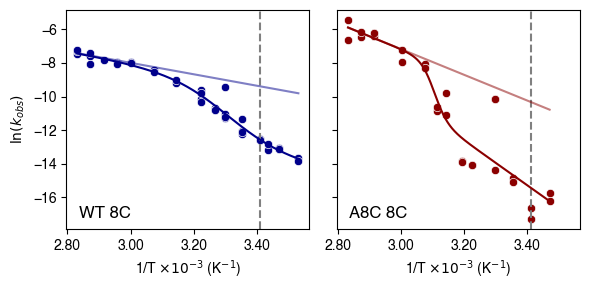

In [6]:
# filter disp_name "4U_wt"
site = 8

# perform fits
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site)
fits_filt2, melt_result2, smooth_x2, smooth_y2, lnkobs_20C2, lnkobs_20C_err2, lnkadd2, lnkadd_err2, kadd_curve_x2, kadd_curve_y2 = fit_melting_curve(fits, '4U_a8c', site)

# plot log_kappa vs 1/T (axs[0]) and log_kobs vs 1/T (axs[1])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}
# vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].plot(smooth_x, smooth_y, color=color_dict['4U_wt'])
axs[0].plot(kadd_curve_x, kadd_curve_y, color=color_dict['4U_wt'], alpha = 0.5)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT {site}C', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
# plot 4U_a8c
sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].plot(smooth_x2, smooth_y2, color=color_dict['4U_a8c'])
axs[1].plot(kadd_curve_x2, kadd_curve_y2, color=color_dict['4U_a8c'], alpha = 0.5)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C {site}C', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
#plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/ind_kadd_fit.pdf')
plt.show()

### Aggregated $k_{add}$ fits

In [19]:
def aggregated_lmfit_melted(fits, sites, disp_name, fit_param = 'log_kobs'):
    # 'log_kobsT' for eyring or 'log_kobs' for arrhenius
    
    all_melted = fits.copy()#[fits['temperature'] > 59]
    # filt name contains "4U_wt" or "4U_a8c"
    all_melted = all_melted[all_melted['disp_name'].str.contains(disp_name)]
    all_melted = all_melted[all_melted['temperature'] > 59]

    all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
    all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']
    all_melted.loc[:, 'log_kobsT'] = all_melted['log_kobs'] + np.log(all_melted['inv_temp'])

    #if disp_name == 'hiv_':
    #    all_melted = all_melted[all_melted['log_kobs'] > -7.75]

    select_melted = all_melted[all_melted['site'].isin(sites)]

    # Compute mean and standard deviation of log_kobs at each inv_temp for weighting
    grouped = select_melted.groupby(['inv_temp', 'disp_name'])[fit_param].agg(['mean', 'std']).reset_index()
    grouped['weight'] = 1 / (grouped['std'] ** 2)  # Inverse variance weighting

    # use your per-point 1-sigma (same units as y)
    # sigma = df_filt['log_kobs_err'].to_numpy()

    # safety: drop/clip invalid sigmas
    # mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    # x, y, sigma = x[mask], y[mask], sigma[mask]

    # weights = 1/sigma for WLS
    # weights = 1.0 / sigma

    # weighted fit
    # result = model.fit(
    # y, params, inv_t=x,
    # weights=weights,
    # nan_policy='omit',
    # scale_covar=False, # treat provided sigmas as absolute (no rescaling)
    # )

    grouped.plot(x='inv_temp', y='mean', kind='scatter', color = 'black')

    # weighted linear fit
    model = LinearModel()
    params = model.make_params()
    result = model.fit(grouped['mean'], params, x=grouped['inv_temp'], weights=grouped['weight'])
    return result

4U_A
4U_C
4U_G
No data for 4U_G
hiv_A
hiv_C
hiv_G


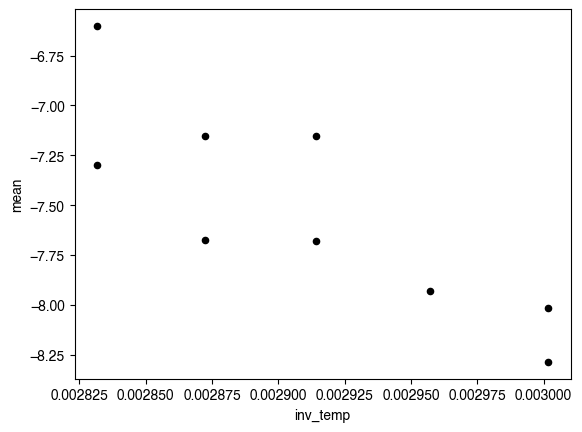

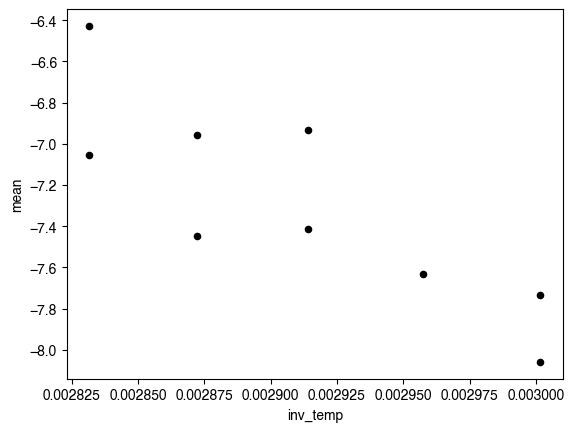

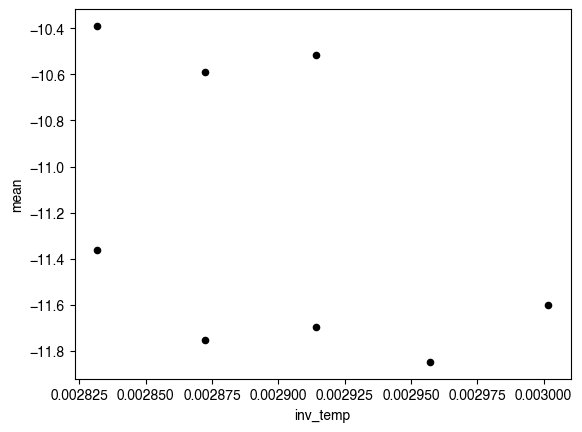

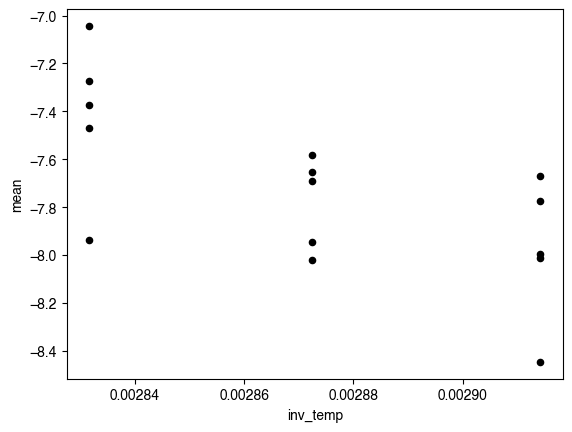

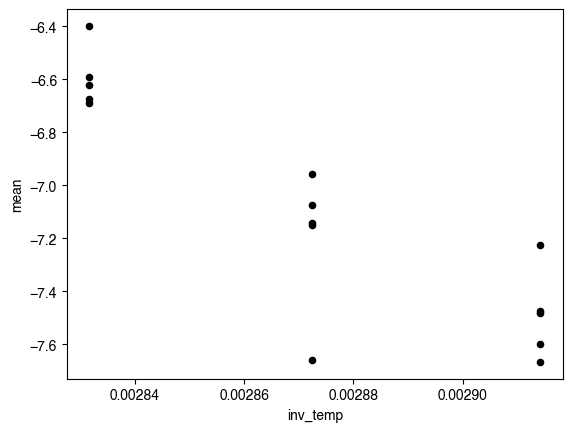

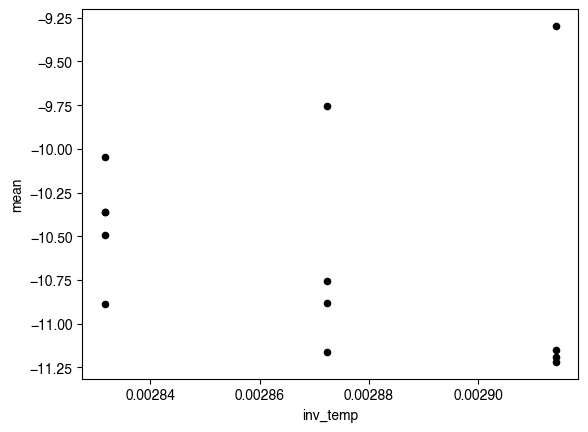

In [20]:
sites_dict_hiv = {'C': [19, 24, 29, 30, 37, 39, 41, 44, 45], 'A': [2, 3, 20, 22, 27, 35, 61, 62], 
                  'G': [17, 18, 21, 26, 28, 32, 33, 34, 36, 43]}
sites_dict_4U = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25], 'G': [19, 21, 31]}

sites_dict = {'hiv_': sites_dict_hiv, '4U_': sites_dict_4U}

arrhenius_aggfits = {}
for construct in ['4U_', 'hiv_']:
    for base in ['A', 'C', 'G']:
        dict_key = f'{construct}{base}'
        print(dict_key)
        try:
            arrhenius_aggfits[dict_key] = aggregated_lmfit_melted(fits, sites_dict[construct][base], construct, 'log_kobs')
        except:
            print(f'No data for {dict_key}')
            continue

# Load NTP data
all_fit_params = '../05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8'].copy()
peak8['lnkaddT'] = peak8['lnkadd'] + np.log(peak8['1/T'])

for ntp in ['ATP', 'CTP', 'GTP']:
    peak8_ntp = peak8[peak8['ntp'] == ntp]
    dict_key = f'nmr_{ntp[0]}'

    # arrhenius
    model = LinearModel()
    params = model.make_params()
    result = model.fit(peak8_ntp['lnkadd'], params, x=peak8_ntp['1/T'])
    arrhenius_aggfits[dict_key] = result

<Axes: title={'center': 'Model(linear)'}, xlabel='x', ylabel='y'>

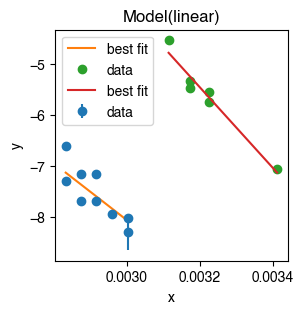

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

#arrhenius_aggfits['4U_C'].plot_fit(ax = ax)
arrhenius_aggfits['4U_A'].plot_fit(ax = ax)
arrhenius_aggfits['nmr_A'].plot_fit(ax = ax)

<Axes: title={'center': 'Model(linear)'}, xlabel='x', ylabel='y'>

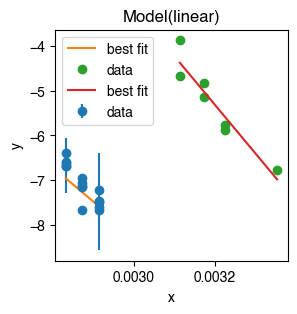

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

#arrhenius_aggfits['4U_C'].plot_fit(ax = ax)
arrhenius_aggfits['hiv_C'].plot_fit(ax = ax)
arrhenius_aggfits['nmr_C'].plot_fit(ax = ax)

In [30]:
arrhenius_aggfits['nmr_A']

In [11]:
arrhenius_aggfits['hiv_C'].eval_uncertainty(x = 1 / (273.15 + 25), sigma = 1)

1.7914567219413255

### Using statsmodel (updated 10/24/25)

In [12]:
sites_dict_hiv = {'C': [19, 24, 29, 30, 37, 39, 41, 44, 45], 'A': [2, 3, 20, 22, 27, 35, 61, 62], 
                  'G': [17, 18, 21, 26, 28, 32, 33, 34, 36, 43]}
sites_dict_4U = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25], 'G': [19, 21, 31]}

sites_dict = {'hiv_': sites_dict_hiv, '4U_': sites_dict_4U}

arrhenius_aggfits_statsmodel = {}
for construct in ['4U_', 'hiv_']:
    for base in ['A', 'C', 'G']:
        dict_key = f'{construct}{base}'
        print(dict_key)
        try:
            arrhenius_aggfits_statsmodel[dict_key] = aggregated_statsmodels_melted(fits, sites_dict[construct][base], construct, 'log_kobs', resturn_grouped=True)
        except:
            print(f'No data for {dict_key}')
            continue
arrhenius_aggfits_statsmodel

4U_A
No data for 4U_A
4U_C
No data for 4U_C
4U_G
No data for 4U_G
hiv_A
No data for hiv_A
hiv_C
No data for hiv_C
hiv_G
No data for hiv_G


{}

In [13]:
linear_model, predictor = statsmodels_melted_no_agg(fits, sites_dict[construct][base], construct, 'log_kobs')
linear_model.summary()

# plot fit from linear_model (statsmodels)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# scatter all data points used in the fit
fits_filt = fits[fits['disp_name'].str.contains(construct)]
fits_filt = fits_filt[fits_filt['site'].isin(sites_dict[construct][base])]
fits_filt = fits_filt[fits_filt['temperature'] > 59]
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color='gray', ax=ax)

NameError: name 'statsmodels_melted_no_agg' is not defined

### Melt curve with aggregated kadd curves

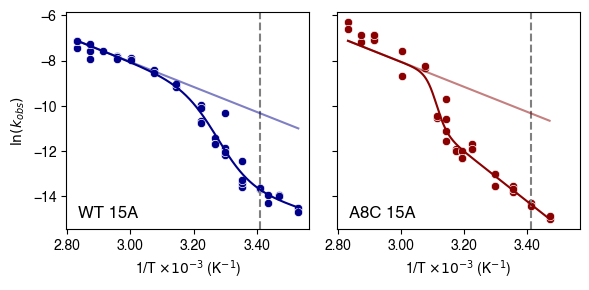

In [ ]:
# filter disp_name "4U_wt"
site = 15

# perform fits
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site, arrhenius_aggfits['4U_A'])
fits_filt2, melt_result2, smooth_x2, smooth_y2, lnkobs_20C2, lnkobs_20C_err2, lnkadd2, lnkadd_err2, kadd_curve_x2, kadd_curve_y2 = fit_melting_curve(fits, '4U_a8c', site, arrhenius_aggfits['4U_A'])

# 4U_A aggregated arrhenius linear fit result

# plot log_kappa vs 1/T (axs[0]) and log_kobs vs 1/T (axs[1])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}
# vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].plot(smooth_x, smooth_y, color=color_dict['4U_wt'])
axs[0].plot(kadd_curve_x, kadd_curve_y, color=color_dict['4U_wt'], alpha = 0.5)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT {site}A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
# plot 4U_a8c
sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].plot(smooth_x2, smooth_y2, color=color_dict['4U_a8c'])
axs[1].plot(kadd_curve_x2, kadd_curve_y2, color=color_dict['4U_a8c'], alpha = 0.5)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C {site}A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
#plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/ind_kadd_fit.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


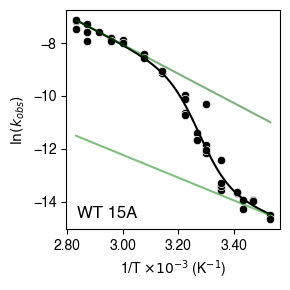

In [ ]:
# filter disp_name "4U_wt"
site = 15

# perform fits
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site, arrhenius_aggfits['4U_A'])

# 4U_A aggregated arrhenius linear fit result

# plot log_kappa vs 1/T (ax) and log_kobs vs 1/T (axs[1])
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
formatter = FuncFormatter(thousands)
# vertical line at 20C

# plot lower baseline
lower_baseline = melt_result.params['a'].value * smooth_x + melt_result.params['b'].value

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color='black', ax=ax)
ax.plot(smooth_x, smooth_y, color='black')
ax.plot(kadd_curve_x, kadd_curve_y, color='darkgreen', alpha = 0.5) # upper baseline
ax.plot(smooth_x, lower_baseline, color='green', alpha = 0.5) # lower baseline
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.annotate(f'WT {site}A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('representative_2statemelt_fit.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


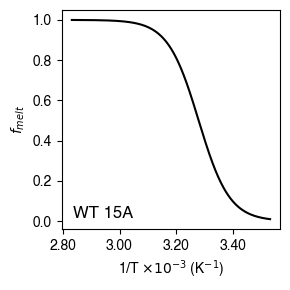

In [ ]:
def conformational_melt(x, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987 # kcal/(mol*K)
    R = 0.0083145 # J/(mol*K)
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1

    return fracu, fracf


# filter disp_name "4U_wt"
site = 15

# perform fits
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site, arrhenius_aggfits['4U_A'])

# 4U_A aggregated arrhenius linear fit result

# plot log_kappa vs 1/T (ax) and log_kobs vs 1/T (axs[1])
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
formatter = FuncFormatter(thousands)
# vertical line at 20C

# plot conformational melt
fracu, fracf = conformational_melt(smooth_x, melt_result.params['f'].value, melt_result.params['g'].value)

# plot 4U_wt
#sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color='black', ax=ax)
#ax.plot(smooth_x, smooth_y, color='black')
ax.plot(smooth_x, fracu, color='black') # lower baseline
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$f_{melt}$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.annotate(f'WT {site}A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('representative_conf_melt_fit.pdf')
plt.show()

### Convergence across all positions

In [ ]:
# TO FIX agg_A_fit (no more)

def plot_n_save_2statemelt(fits, sites, base, ss_site, disp_name, agg_kadd_fit, label = None, temp = 20):
    #

    store_results = []

    # plot log_kappa vs 1/T (ax) and log_kobs vs 1/T (ax)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    formatter = FuncFormatter(thousands)
    for site in sites:
        # perform fits
        fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, disp_name, site, agg_kadd_fit)

        lnkobs_at_temp = melt_result.eval(x = 1 / (273.15 + temp))
        lnkobs_at_temp_err = melt_result.eval_uncertainty(x = 1 / (273.15 + temp))

        # store results
        store_results.append([site, disp_name, lnkobs_at_temp, lnkobs_at_temp_err])

        # plot 4U_wt
        sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', alpha = 0.15, ax=ax)
        ax.plot(smooth_x, smooth_y, label = site)

    melt_fits = pd.DataFrame(store_results, columns = ['site', 'disp_name', f'lnkobs_{temp}C', f'lnkobs_{temp}C_err'])
    melt_fits[f'lnkadd_{temp}C'] = agg_kadd_fit.eval(x = 1/(273.15 + temp))
    melt_fits[f'lnkadd_{temp}C_err'] = agg_kadd_fit.eval_uncertainty(x = 1/(273.15 + temp))
    melt_fits['base'] = base

    if ss_site == None:
        # plot upper baseline
        ax.plot(kadd_curve_x, kadd_curve_y, color='black', label = r'agg. $k_{add}$')
    else:
        # plot site 18 (linear)
        fits_filt = fits[(fits['disp_name'] == disp_name) & (fits['site'] == ss_site)].copy()
        fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
        fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']
        m_18, b_18 = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
        x_18 = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
        y_18 = m_18 * x_18 + b_18
        sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color= 'black', alpha = 0.5, ax=ax)
        ax.plot(x_18, y_18, color = 'black', label = 18)

    # vertical line at 20C
    ax.axvline(1/(273.15 + 20), color='gray', linestyle='--', alpha = 0.3, zorder = 0)

    ax.xaxis.set_major_formatter(formatter)
    ax.set_ylabel(r'$\ln(k_{obs})$')
    ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
    #ax.annotate(f'WT', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
    plt.legend(frameon = False, fontsize = 9)

    plt.tight_layout()
    if label == None:
        plt.savefig(f'{disp_name}_{base}_2statemelt_fits_{temp}C.pdf')
    else:
        plt.savefig(f'{disp_name}_{base}_2statemelt_fits_{temp}C_{label}.pdf')
    plt.show()

    return melt_fits

In [ ]:
temp = 20
fourU_18_manual_calc = fits[(fits['disp_name'].isin(['4U_wt', '4U_a8c'])) & (fits['site'] == 18) & (fits['temperature'] == temp)]
fourU_18_manual_calc.loc[:, 'log_kobs'] = fourU_18_manual_calc['log_kappa'] + fourU_18_manual_calc['log_kdeg']
fourU_18_manual_calc['base'] = 'A'
fourU_18_manual_calc[f'lnkadd_{temp}C'] = arrhenius_aggfits['4U_A'].eval(x = 1/(273.15 + temp))
fourU_18_manual_calc[f'lnkadd_{temp}C_err'] = arrhenius_aggfits['4U_A'].eval_uncertainty(x = 1/(273.15 + temp))
fourU_18_manual_calc.to_csv(f'manual_fourU_18_{temp}C.csv')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_10648/4136340067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourU_18_manual_calc.loc[:, 'log_kobs'] = fourU_18_manual_calc['log_kappa'] + fourU_18_manual_calc['log_kdeg']
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_10648/4136340067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourU_18_manual_calc['base'] = 'A'
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_10648/4136340067.py:5: SettingWithCopyWarning: 
A v

In [ ]:
temp = 25
fourU_18_manual_calc = fits[(fits['disp_name'].isin(['4U_wt', '4U_a8c'])) & (fits['site'] == 18) & (fits['temperature'] == temp)]
fourU_18_manual_calc.loc[:, 'log_kobs'] = fourU_18_manual_calc['log_kappa'] + fourU_18_manual_calc['log_kdeg']
fourU_18_manual_calc['base'] = 'A'
fourU_18_manual_calc[f'lnkadd_{temp}C'] = arrhenius_aggfits['4U_A'].eval(x = 1/(273.15 + temp))
fourU_18_manual_calc[f'lnkadd_{temp}C_err'] = arrhenius_aggfits['4U_A'].eval_uncertainty(x = 1/(273.15 + temp))
fourU_18_manual_calc.to_csv(f'manual_fourU_18_{temp}C.csv')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_10648/905447254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourU_18_manual_calc.loc[:, 'log_kobs'] = fourU_18_manual_calc['log_kappa'] + fourU_18_manual_calc['log_kdeg']
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_10648/905447254.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourU_18_manual_calc['base'] = 'A'
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_10648/905447254.py:5: SettingWithCopyWarning: 
A valu

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


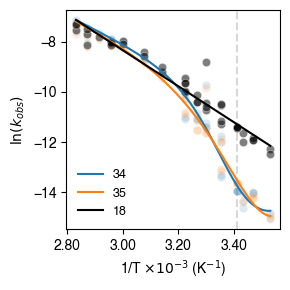

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


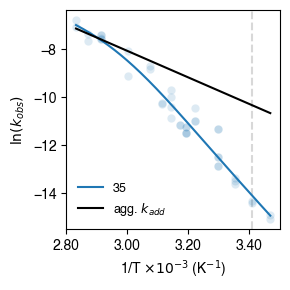

In [ ]:
melt_fits_wt = plot_n_save_2statemelt(fits, [34, 35], 'A', 18, '4U_wt', arrhenius_aggfits['4U_A'])
melt_fits_a8c = plot_n_save_2statemelt(fits, [35], 'A', None, '4U_a8c', arrhenius_aggfits['4U_A'])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


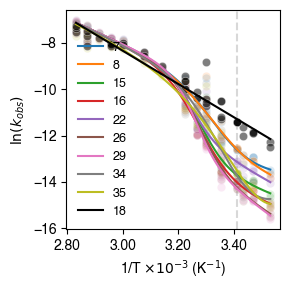

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


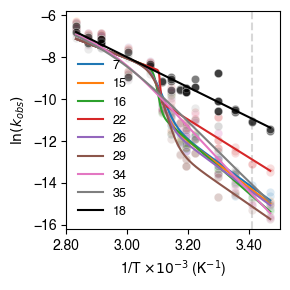

/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/lmfit/models.py:235: RankWarning: Polyfit may be poorly conditioned
  sval, oval = np.polyfit(x, data, 1)
/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/lmfit/models.py:235: RankWarning: Polyfit may be poorly conditioned
  sval, oval = np.polyfit(x, data, 1)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


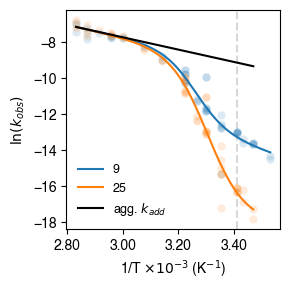

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


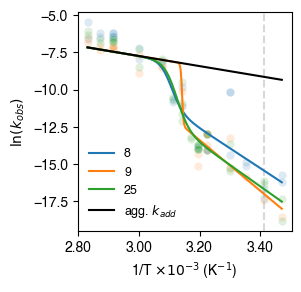

In [ ]:
melt_fits_wt = plot_n_save_2statemelt(fits, [7, 8, 15, 16, 22, 26, 29, 34, 35], 'A', 18, '4U_wt', arrhenius_aggfits['4U_A'])
melt_fits_a8c = plot_n_save_2statemelt(fits, [7, 15, 16, 22, 26, 29, 34, 35], 'A', 18, '4U_a8c', arrhenius_aggfits['4U_A'])
melt_fits_wt_C = plot_n_save_2statemelt(fits, [9, 25], 'C', None, '4U_wt', arrhenius_aggfits['4U_C'])
melt_fits_a8c_C = plot_n_save_2statemelt(fits, [8, 9, 25], 'C', None, '4U_a8c', arrhenius_aggfits['4U_C'])

melt_fits = pd.concat([melt_fits_wt, melt_fits_a8c, melt_fits_wt_C, melt_fits_a8c_C], axis = 0)
melt_fits.to_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/07_2state_melt/4U_melt_fits.csv', index = False)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


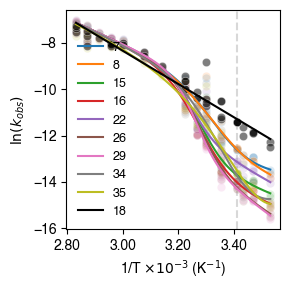

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


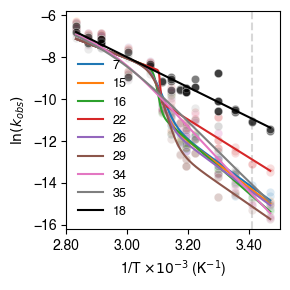

/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/lmfit/models.py:235: RankWarning: Polyfit may be poorly conditioned
  sval, oval = np.polyfit(x, data, 1)
/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/lmfit/models.py:235: RankWarning: Polyfit may be poorly conditioned
  sval, oval = np.polyfit(x, data, 1)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


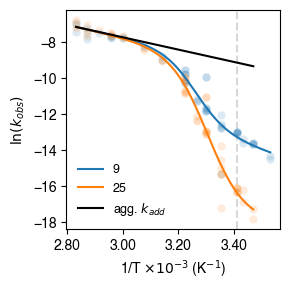

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


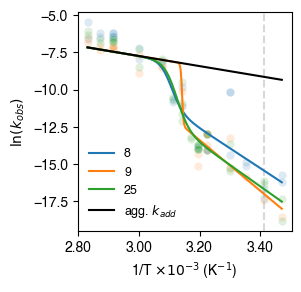

In [ ]:
melt_fits_wt = plot_n_save_2statemelt(fits, [7, 8, 15, 16, 22, 26, 29, 34, 35], 'A', 18, '4U_wt', arrhenius_aggfits['4U_A'], temp = 25)
melt_fits_a8c = plot_n_save_2statemelt(fits, [7, 15, 16, 22, 26, 29, 34, 35], 'A', 18, '4U_a8c', arrhenius_aggfits['4U_A'], temp = 25)
melt_fits_wt_C = plot_n_save_2statemelt(fits, [9, 25], 'C', None, '4U_wt', arrhenius_aggfits['4U_C'], temp = 25)
melt_fits_a8c_C = plot_n_save_2statemelt(fits, [8, 9, 25], 'C', None, '4U_a8c', arrhenius_aggfits['4U_C'], temp = 25)

melt_fits = pd.concat([melt_fits_wt, melt_fits_a8c, melt_fits_wt_C, melt_fits_a8c_C], axis = 0)
melt_fits.to_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/07_2state_melt/4U_melt_fits_25C.csv', index = False)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


7
15
16
26
29


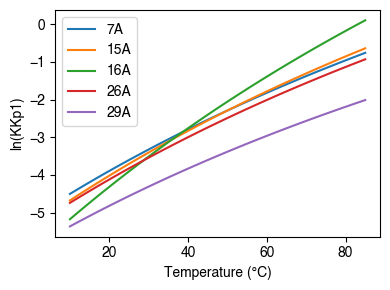

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

for site in [7, 15, 16, 26, 29]:
    print(site)
    fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_a8c', site, arrhenius_aggfits['4U_A'])
    m_diff = melt_result.params['a'].value - melt_result.params['c'].value
    b_diff = melt_result.params['b'].value - melt_result.params['d'].value

    # range of temps from
    temps = np.linspace(10, 85, 100)
    x_arr = 1 / (273.15 + temps)
    ln_KKp1 = m_diff * x_arr + b_diff
    KKp1 = np.exp(ln_KKp1)
    K = KKp1 / (KKp1 - 1)
    dG = -0.001987 * (273.15 + temps) * np.log(K)
    ax.plot(temps, ln_KKp1, label=f'{site}A')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('ln(KKp1)')
ax.legend()
plt.tight_layout()
plt.savefig('4U_a8c_lnKKp1_vs_temp.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


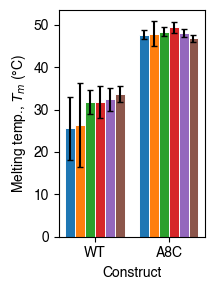

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


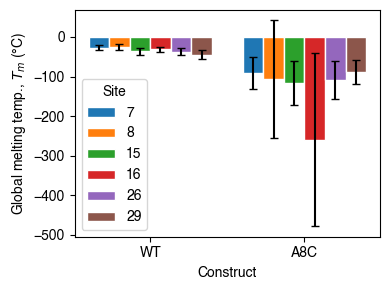

In [ ]:
# TO FIX agg_A_fit (no more)

def extract_2statemelt_global(fits, sites, base, ss_site, disp_name, agg_kadd_fit, label = None):
    #

    store_results = []


    for site in sites:
        # perform fits
        fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, disp_name, site, agg_kadd_fit)

        tm = melt_result.params['g'].value
        tm_err = melt_result.params['g'].stderr
        dH = melt_result.params['f'].value # in kJ/mol
        dH_err = melt_result.params['f'].stderr

        dH_kcal = dH / 4.184 # convert to kcal/mol
        dH_kcal_err = dH_err / 4.184

        # store results
        store_results.append([site, disp_name, tm, tm_err, dH_kcal, dH_kcal_err])

    result_df = pd.DataFrame(store_results, columns = ['site', 'disp_name', 'tm', 'tm_err', 'dH_kcal', 'dH_kcal_err'])

    return result_df


def plot_2statemelt_global(result_df, disp_name, base, label=None):
    fig, ax = plt.subplots(1, 1, figsize=(2.25, 3))

    # Grouped bar setup
    constructs = result_df['disp_name'].unique()
    sites = result_df['site'].unique()
    bar_width = 0.8 / len(sites)
    x = np.arange(len(constructs))

    # Plot each site's bars
    for i, site in enumerate(sites):
        subset = result_df[result_df['site'] == site]
        # Ensure same order of constructs
        subset = subset.set_index('disp_name').reindex(constructs).reset_index()
        heights = subset['tm']
        errors = subset['tm_err']

        ax.bar(
            x + i * bar_width,
            heights,
            yerr=errors,
            width=bar_width,
            label=str(site),
            capsize=2,
            linewidth=0.7,
            edgecolor='white',
        )

    ax.set_xticks(x + bar_width * (len(sites) - 1) / 2)
    ax.set_xticklabels(['WT', 'A8C'])
    ax.set_ylabel(r'Melting temp., $T_m$ (°C)')
    ax.set_xlabel('Construct')
    #ax.legend(title='Site')

    filename = f'{disp_name}_{base}_2statemelt_globalTM'
    if label:
        filename += f'_{label}'
    # legend outside
    # hide legend
    ax.legend().set_visible(False)
    #ax.legend(
    #    bbox_to_anchor=(1.05, 1), loc='upper left'
    #)
    plt.tight_layout()

    plt.savefig(f'{filename}.pdf')

    plt.show()

    return 0


def plot_2statemelt_global_dH(result_df, disp_name, base, label=None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Grouped bar setup
    constructs = result_df['disp_name'].unique()
    sites = result_df['site'].unique()
    bar_width = 0.8 / len(sites)
    x = np.arange(len(constructs))

    # Plot each site's bars
    for i, site in enumerate(sites):
        subset = result_df[result_df['site'] == site]
        # Ensure same order of constructs
        subset = subset.set_index('disp_name').reindex(constructs).reset_index()
        heights = subset['dH_kcal']
        errors = subset['dH_kcal_err']

        ax.bar(
            x + i * bar_width,
            heights,
            yerr=errors,
            width=bar_width,
            label=str(site),
            capsize=3,
            linewidth=1,
            edgecolor='white',
        )

    ax.set_xticks(x + bar_width * (len(sites) - 1) / 2)
    ax.set_xticklabels(['WT', 'A8C'])
    ax.set_ylabel(r'Global melting temp., $T_m$ (°C)')
    ax.set_xlabel('Construct')
    ax.legend(title='Site')
    plt.tight_layout()

    filename = f'{disp_name}_{base}_2statemelt_globaldH'
    if label:
        filename += f'_{label}'
    # no legend
    #ax.legend().set_visible(False)
    plt.savefig(f'{filename}.pdf')

    plt.show()

    return 0


wt_tms = extract_2statemelt_global(fits, [7, 8, 15, 16, 26, 29], 'A', 18, '4U_wt', arrhenius_aggfits['4U_A'])
a8c_tms = extract_2statemelt_global(fits, [7, 8, 15, 16, 26, 29], 'A', 18, '4U_a8c', arrhenius_aggfits['4U_A'])

# barplot

plot_2statemelt_global(pd.concat([wt_tms, a8c_tms], axis = 0), '4U', 'A')
plot_2statemelt_global_dH(pd.concat([wt_tms, a8c_tms], axis = 0), '4U', 'A')



# calculate mean dH and dH_err 
mean_wt_dH = wt_tms['dH_kcal'].mean()
mean_wt_dH_err = wt_tms['dH_kcal_err'].mean()
mean_a8c_dH = a8c_tms['dH_kcal'].mean()
mean_a8c_dH_err = a8c_tms['dH_kcal_err'].mean()


In [ ]:
a8c_tms

,site,disp_name,tm,tm_err,dH_kcal,dH_kcal_err
0,7,4U_a8c,47.644021,1.107780,-91.036408,39.502856
1,8,4U_a8c,47.936712,3.006115,-106.925834,149.099704
2,15,4U_a8c,48.409489,0.995614,-116.794137,55.141350
3,16,4U_a8c,49.448441,1.326052,-259.279128,219.257818
4,26,4U_a8c,48.025471,0.985701,-109.044160,48.808997
5,29,4U_a8c,46.861676,0.840546,-88.999206,29.778671


### HIV ANALYSIS below

In [ ]:
import scipy.constants as sc

In [ ]:
hiv_A_lnkadd = arrhenius_aggfits['hiv_A'].eval(x = 1/(273.15 + 25))
hiv_A_lnkadd_err = arrhenius_aggfits['hiv_A'].eval_uncertainty(x = 1/(273.15 + 25))
hiv_C_lnkadd = arrhenius_aggfits['hiv_C'].eval(x = 1/(273.15 + 25))
hiv_C_lnkadd_err = arrhenius_aggfits['hiv_C'].eval_uncertainty(x = 1/(273.15 + 25))
hiv_G_lnkadd = arrhenius_aggfits['hiv_G'].eval(x = 1/(273.15 + 25))
hiv_G_lnkadd_err = arrhenius_aggfits['hiv_G'].eval_uncertainty(x = 1/(273.15 + 25))

print(f'lnkadd A: {hiv_A_lnkadd} +/- {hiv_A_lnkadd_err}')
print(f'lnkadd C: {hiv_C_lnkadd} +/- {hiv_C_lnkadd_err}')
print(f'lnkadd G: {hiv_G_lnkadd} +/- {hiv_G_lnkadd_err}')


lnkadd A: -10.127056924457522 +/- 0.8265934032394847
lnkadd C: -10.95811613835019 +/- 1.7914567219413255
lnkadd G: -14.484437473821146 +/- 0.610870006974812


In [ ]:
# filter out disp_name contain 'hiv_'
hiv_fits = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.064.HIV_reanalysis/hiv_all_global.csv')[fits.columns[:-1]]
hiv_fits


,site,log_kappa,log_kdeg,log_fmod_0,r2,stderr_log_kappa,stderr_log_kdeg,stderr_log_fmod_0,rg_id,temperature,disp_name
0,2,-3.884380,-7.952639,-5.852045,0.978974,0.085701,0.0,4.779622e-01,83,25,hiv_wt
1,2,-3.759968,-8.079940,-6.492875,0.996062,0.036836,0.0,4.284457e-01,84,25,hiv_wt
2,3,-3.824006,-7.952639,-6.442080,0.996086,0.036696,0.0,3.917364e-01,83,25,hiv_wt
3,3,-3.784439,-8.079940,-6.185537,0.995088,0.041134,0.0,3.435104e-01,84,25,hiv_wt
4,17,-6.978075,-7.952639,-7.683858,0.959306,0.118979,0.0,1.911802e-01,83,25,hiv_wt
...,...,...,...,...,...,...,...,...,...,...,...
1395,62,-5.086192,-2.578028,-34.013792,0.952348,0.097301,0.0,2.499677e+11,106,80,hiv_es2
1396,63,-6.260034,-2.865611,-5.789267,0.527564,0.547108,0.0,2.838220e-01,105,80,hiv_es2
1397,63,-7.298995,-2.578028,-5.646113,0.352422,0.783016,0.0,1.309491e-01,106,80,hiv_es2
1398,64,-5.392128,-2.865611,-6.253062,0.886012,0.207776,0.0,4.072667e-01,105,80,hiv_es2


In [ ]:
def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err

def get_base(site, disp_name):

    # get experimental info
    main_db  = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
    conn = sqlite3.connect(main_db)
    query = """
        SELECT nt.base
        FROM nucleotides nt
        JOIN constructs c ON nt.construct_id = c.id
        WHERE nt.site = ? AND c.disp_name = ?
    """

    base_info = pd.read_sql_query(query, conn, params=(site, disp_name))
    return base_info.iloc[0, 0]


# hiv_25
hiv_25 = hiv_fits[hiv_fits['temperature'] == 25].copy()
hiv_25['base'] = hiv_25.apply(lambda x: get_base(x['site'], x['disp_name']), axis=1)
# filter to base in 'A', 'C'
hiv_25 = hiv_25[hiv_25['base'].isin(['A', 'C', 'G'])]
hiv_25 = hiv_25[hiv_25['disp_name'].str.contains('hiv_')]
hiv_25['lnkobs'] = hiv_25['log_kappa'] + hiv_25['log_kdeg']
hiv_25['lnkobs_err'] = hiv_25['stderr_log_kappa']

# calc kadd using hiv_A if A and hiv_C if C and hiv_G if G
def get_kadd(row):
    if row['base'] == 'A':
        lnkadd = arrhenius_aggfits['hiv_A'].eval(x = 1/(273.15 + 25))
        lnkadd_err = arrhenius_aggfits['hiv_A'].eval_uncertainty(x = 1/(273.15 + 25))
    elif row['base'] == 'C':
        lnkadd = arrhenius_aggfits['hiv_C'].eval(x = 1/(273.15 + 25))
        lnkadd_err = arrhenius_aggfits['hiv_C'].eval_uncertainty(x = 1/(273.15 + 25))
    elif row['base'] == 'G':
        lnkadd = arrhenius_aggfits['hiv_G'].eval(x = 1/(273.15 + 25))
        lnkadd_err = arrhenius_aggfits['hiv_G'].eval_uncertainty(x = 1/(273.15 + 25))

    return lnkadd, lnkadd_err

# apply to each row
hiv_25[['lnkadd', 'lnkadd_err']] = hiv_25.apply(get_kadd, axis=1, result_type='expand')

# filter stderr_log_kappa > 10
hiv_25 = hiv_25[hiv_25['stderr_log_kappa'] < 10]
hiv_25.to_csv('hiv_25.csv', index = False)

# filter to A's and C's
#hiv_25 = hiv_25[hiv_25['base'].isin(['A', 'C'])]

# columns needed site,disp_name,lnkobs,lnkobs_err,lnkadd,lnkadd_err,base
hiv_kobs_kadd_vals = hiv_25[['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base']].copy()
hiv_kobs_kadd_vals.to_csv('hiv_kobs_kadd_vals_25_ACG.csv', index = False)

In [ ]:
pd.read_csv('hiv_25.csv')

,site,log_kappa,log_kdeg,log_fmod_0,r2,stderr_log_kappa,stderr_log_kdeg,stderr_log_fmod_0,rg_id,temperature,disp_name,base,lnkobs,lnkobs_err,lnkadd,lnkadd_err
0,2,-3.884380,-7.952639,-5.852045,0.978974,0.085701,0.0,0.477962,83,25,hiv_wt,A,-11.837019,0.085701,-10.127057,0.826593
1,2,-3.759968,-8.079940,-6.492875,0.996062,0.036836,0.0,0.428446,84,25,hiv_wt,A,-11.839907,0.036836,-10.127057,0.826593
2,3,-3.824006,-7.952639,-6.442080,0.996086,0.036696,0.0,0.391736,83,25,hiv_wt,A,-11.776645,0.036696,-10.127057,0.826593
3,3,-3.784439,-8.079940,-6.185537,0.995088,0.041134,0.0,0.343510,84,25,hiv_wt,A,-11.864379,0.041134,-10.127057,0.826593
4,17,-6.978075,-7.952639,-7.683858,0.959306,0.118979,0.0,0.191180,83,25,hiv_wt,G,-14.930714,0.118979,-14.484437,0.610870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,61,-3.220913,-8.286618,-5.802685,0.987534,0.066430,0.0,0.622422,100,25,hiv_es2,A,-11.507531,0.066430,-10.127057,0.826593
251,62,-3.950220,-8.224969,-8.733335,0.953736,0.128696,0.0,11.266665,99,25,hiv_es2,A,-12.175189,0.128696,-10.127057,0.826593
252,62,-4.029657,-8.286618,-6.344407,0.960132,0.118908,0.0,0.869322,100,25,hiv_es2,A,-12.316276,0.118908,-10.127057,0.826593
253,64,-4.944135,-8.224969,-5.913939,0.953633,0.127839,0.0,0.249731,99,25,hiv_es2,C,-13.169104,0.127839,-10.958116,1.791457
